In [1]:
import os, yaml, sys
import numpy as np
from sklearn.decomposition import IncrementalPCA
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
import torch 
import joblib
from torchvision import models
import matplotlib.pyplot as plt
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import print_wise, get_layer_output_shape, get_device
from image_processing.utils import read_video, resize_video_array
device=get_device()

In [2]:
def pass_video(paths, rank, feature_extractor, layer_name, fn, device, max_len=20, new_height=224, new_width=224):
    video = read_video(paths, rank, fn, vid_duration=max_len)
    print(video.shape)
    inputs = resize_video_array(video, new_height, new_width, normalize=True)
    inputs = torch.from_numpy(inputs).float().to(device)
    inputs = inputs.permute(0, 3, 1, 2)
    with torch.no_grad():
        feats = feature_extractor(inputs)[layer_name]
        print("feats", feats.shape)
        feats = feats.reshape(feats.size(0), -1).cpu().numpy()
    return feats

In [3]:
rank = 0
device = get_device()
model_name = "alexnet"
layer_name = "features.0"
model_cls = getattr(models, model_name)
model = model_cls(weights=True).to(device).eval()
feature_extractor = create_feature_extractor(model, return_nodes=[layer_name]).to(device)

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
fn = "steve1.mp4"
f = pass_video(paths, rank, feature_extractor, layer_name, fn, device, max_len=3)

20:01:38 - rank 0 steve1.mp4 read successfully
(90, 1080, 1920, 3)
feats torch.Size([90, 64, 55, 55])


In [10]:
pca_path = f"{paths['livingstone_lab']}/tiziano/models"
video_type = "faceswap"
ipca = joblib.load(f"{pca_path}/{video_type}_{model_name}_{layer_name}_ipca_1000_PCs.pkl")
evecs = ipca.components_

In [11]:
f_proj = f@evecs.T

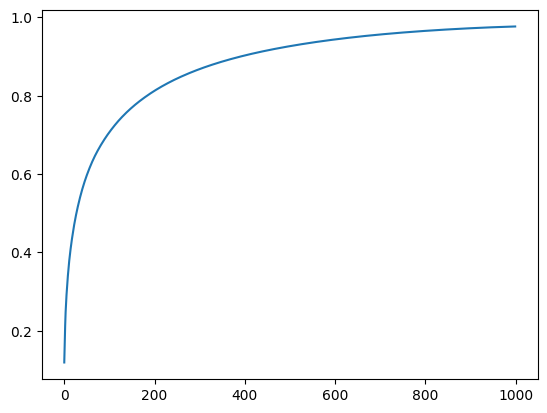

In [12]:
plt.plot(np.cumsum(ipca.explained_variance_ratio_))

In [13]:
video = read_video(paths, rank, fn, vid_duration=3)
v_list = []
for i in range(video.shape[0]):
    v_list.append(video[i,:,:,:])

20:02:04 - rank 0 steve1.mp4 read successfully


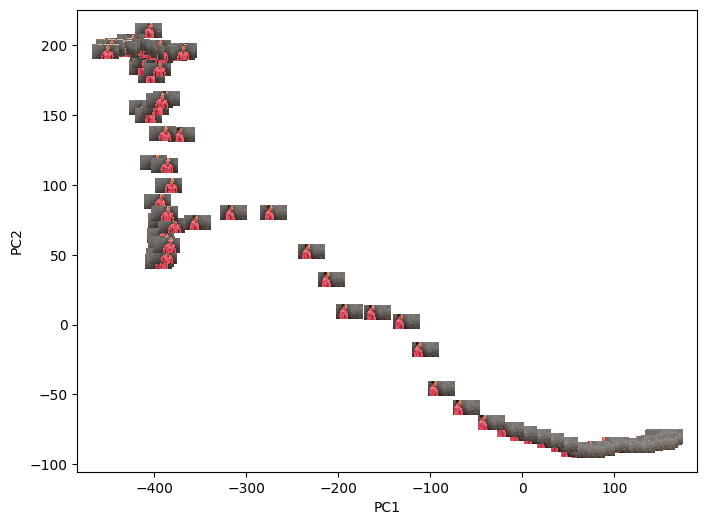

In [14]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(8, 6))
f_ = f_proj[:,[0, 1]]
# Base scatter (optional, but useful)
ax.scatter(f_[:, 0], f_[:, 1], s=10, alpha=0.3)

for (x, y), img in zip(f_, v_list):
    im = OffsetImage(img, zoom=0.01)   # control thumbnail size here
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()